# MNIST

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
    
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from numpy import linalg as LA

database = []
for data_name in ["mnist", "spam"]:
    data = io.loadmat("data/%s_data.mat" % data_name)
    database.append(data)
    print("\nloaded %s data!" % data_name)
    fields = "test_data", "training_data", "training_labels"
    for field in fields:
        print(field, data[field].shape)

mnist_data = database[0]
spam_data = database[1]


loaded mnist data!
test_data (10000, 784)
training_data (60000, 784)
training_labels (60000, 1)

loaded spam data!
test_data (5857, 32)
training_data (5172, 32)
training_labels (5172, 1)


In [2]:
# load training data

train_data = mnist_data['training_data'][:50000]
train_label = mnist_data['training_labels'][:50000]
n_images = len(train_data)

# normalize with L2 norm
L2_norm = np.array([LA.norm(train_data[i]) for i in range(n_images)])
train_data = np.array([train_data[i]/L2_norm[i] for i in range(n_images)])

In [3]:
# load test data

test_data = mnist_data['training_data'][50000:]
test_label = mnist_data['training_labels'][50000:]
n_images_test = len(test_data)

# normalize with L2 norm
L2_norm_test = np.array([LA.norm(test_data[i]) for i in range(n_images_test)])
test_data = np.array([test_data[i]/L2_norm_test[i] for i in range(n_images_test)])

In [4]:
# define useful numbers

n_class = int(max(train_label+1))
dim = len(train_data[0])

print('n_images = ', n_images)
print('n_images_test = ', n_images_test)
print('n_class = ', n_class)
print('dim = ', dim)

n_images =  50000
n_images_test =  10000
n_class =  10
dim =  784


In [47]:
def classes_fn(train_label):
    return [np.where(train_label == n)[0] for n in range(n_class)]

classes = classes_fn(train_label)
classes

[array([    1,    21,    34, ..., 49987, 49989, 49996]),
 array([    3,     6,     8, ..., 49961, 49964, 49972]),
 array([    5,    16,    25, ..., 49975, 49976, 49993]),
 array([    7,    10,    12, ..., 49968, 49981, 49985]),
 array([    2,     9,    20, ..., 49982, 49994, 49998]),
 array([    0,    11,    35, ..., 49991, 49992, 49995]),
 array([   13,    18,    32, ..., 49969, 49970, 49977]),
 array([   15,    29,    38, ..., 49978, 49980, 49986]),
 array([   17,    31,    41, ..., 49990, 49997, 49999]),
 array([    4,    19,    22, ..., 49983, 49984, 49988])]

In [6]:
priors = np.array([len(train_data[classes[i]])/n_images for i in range(n_class)])
priors

array([0.09864, 0.11356, 0.09936, 0.10202, 0.09718, 0.09012, 0.09902,
       0.1035 , 0.09684, 0.09976])

In [48]:
def mean_fn(train_data, classes):
    mean = np.zeros((n_class,dim))

    for n in range(n_class):
        m = [(np.mean(train_data[classes[n]].T[i])) for i in range(dim)]
        mean[n] = np.array(m)
    
    return mean

mean = mean_fn(train_data, classes)

In [120]:
# calculate covariance matrix for each class

cov = np.array([np.cov(train_data[classes[i]].T) for i in range(n_class)])

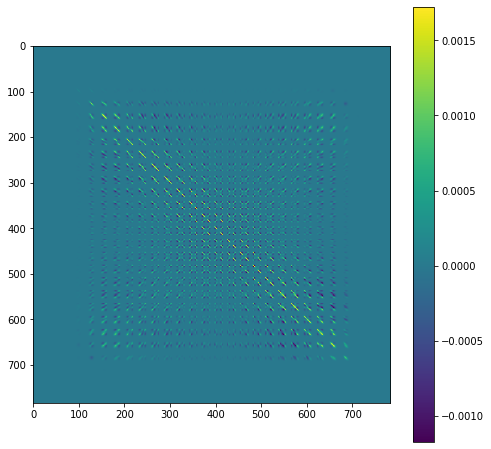

In [121]:
plt.figure(figsize=(8,8))
plt.imshow(cov[0]);
plt.colorbar()
plt.show()

In [10]:
# covariance matrices are usually singular here
# define function that adds a number to the diagonal
# to make it non-singular
# in order to calculate the inverse, or determinant or solve the equation system later on

def cov_add(cov, add):
    new_cov = cov.copy()
    [np.fill_diagonal(new_cov[i], new_cov[i].diagonal() + add) for i in range(n_class)]
    
    return new_cov

In [80]:
def cov_mean_fn(cov):
    
    cov_mean =  np.zeros((dim,dim))
    for n in range(n_class):
        
        cov_mean += cov[n]
    
    return cov_mean

In [94]:
# define function that calculates posterior probabilities
# calculate f_Class_(x) = e^(-0.5q) * prior with q = (x-mean).T * Sigma * (x-mean)
# solve q as linear equation system

# calculate probability with bayes: P(Y=C|x) = f_Class_(x) * prior

def prob(x, mean, cov, priors, kernel = 'LDA'):
    
    center = [x-mean[i] for i in range(n_class)]
    
    # check wether LDA or QDA kernel
    if kernel == 'QDA':
        z = [LA.solve(cov[i], center[i]) for i in range(n_class)] # one covariance matrix for each class
    if kernel == 'LDA':
        cov = cov_mean_fn(cov) # one covariance matrix for all classes
        z = [LA.solve(cov, center[i]) for i in range(n_class)]
        
    q = np.array([(center[i]).dot(z[i]) for i in range(n_class)])
    f = np.array([np.exp(-0.5*q[i]) * priors[i] for i in range(n_class)])
    
    return f

In [103]:
# predicter function
# find highest posterior probability for each image

def predict(test_data, mean, cov, add, priors, sample_size, kernel = 'LDA'):
    
    predicted_data = np.zeros(sample_size)
    
    for idx in range(sample_size):
        x = test_data[idx]
        new_cov = cov_add(cov, add)
        
        f = prob(x, mean, new_cov, priors, kernel = kernel)

        prediction = np.argmax(f)
        predicted_data[idx] = prediction

        
    
    return predicted_data

In [107]:
predicted_data = predict(test_data, mean, cov, 0.001, priors, 50, kernel = 'QDA')
predicted_data

array([3., 8., 6., 9., 6., 4., 5., 3., 8., 4., 5., 2., 3., 8., 4., 8., 1.,
       5., 0., 5., 9., 7., 4., 1., 0., 3., 0., 6., 2., 9., 9., 4., 1., 3.,
       6., 8., 0., 7., 7., 6., 8., 9., 0., 3., 8., 3., 2., 9., 8., 4.])

number training data: 100
13 of 50 test data wrong       0.74 accuracy

number training data: 200
10 of 50 test data wrong       0.8 accuracy

number training data: 500
7 of 50 test data wrong       0.86 accuracy

number training data: 1000
6 of 50 test data wrong       0.88 accuracy

number training data: 2000
5 of 50 test data wrong       0.9 accuracy

number training data: 5000
3 of 50 test data wrong       0.94 accuracy

number training data: 10000
4 of 50 test data wrong       0.92 accuracy

number training data: 30000
3 of 50 test data wrong       0.94 accuracy

number training data: 50000
4 of 50 test data wrong       0.92 accuracy



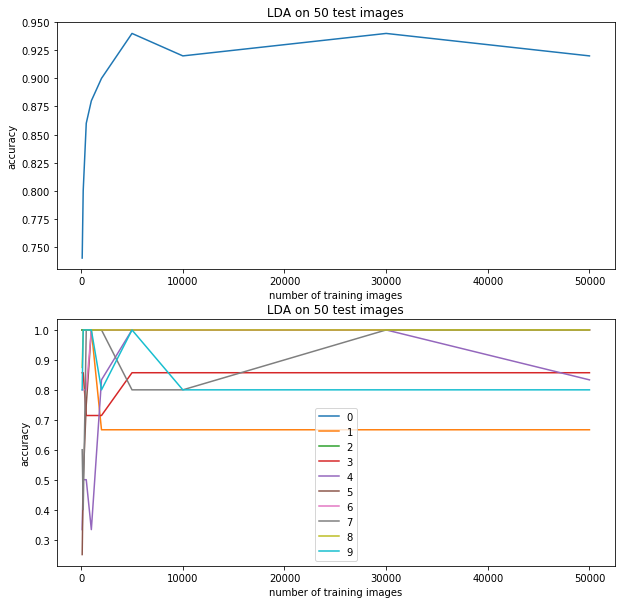

In [406]:
# LDA

sample_size_list = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]

accuracy_list = []
test_digit_counts = [list(test_label[:50]).count(i) for i in range(n_class)]
accuracy_list_digit = []


kernel = 'LDA'
n_test_samples = 50
for n_samples in sample_size_list:
    
    print('number training data: ' + str(n_samples))
    
    classes_few_data = classes_fn(train_label[:n_samples])
    mean_few_data = mean_fn(train_data[:n_samples], classes_few_data)
    cov_few_data = np.array([np.cov(train_data[classes[i]][:n_samples].T) for i in range(n_class)])

    
    predicted_data = predict(test_data, mean_few_data, cov_few_data, 0.001, priors, n_test_samples, kernel = kernel)
    
    ############ calculate total accuracies for every epoch########
    wrong_count = 0
    for idx, pred in enumerate(predicted_data):
        if pred == test_label[idx]:
                wrong_count += 0
        else:
                wrong_count += 1   
        
    accuracy = 1-wrong_count/n_test_samples
    accuracy_list.append(accuracy)
    
    print(str(wrong_count) + ' of ' + str(n_test_samples) + ' test data wrong       ' + str(accuracy) + ' accuracy')
    print('')
    
    ############ calculate accuracies per digit (class) for every epoch########
    
    digit_errors = np.zeros(n_class)
    for i in range(n_test_samples):
    
        if test_label[i] == 0 and predicted_data[i] != 0:
            digit_errors[0] += 1/test_digit_counts[0]
        if test_label[i] == 1 and predicted_data[i] != 1:
            digit_errors[1] += 1/test_digit_counts[1]
        if test_label[i] == 2 and predicted_data[i] != 2:
            digit_errors[2] += 1/test_digit_counts[2]
        if test_label[i] == 3 and predicted_data[i] != 3:
            digit_errors[3] += 1/test_digit_counts[3]
        if test_label[i] == 4 and predicted_data[i] != 4:
            digit_errors[4] += 1/test_digit_counts[4]
        if test_label[i] == 5 and predicted_data[i] != 5:
            digit_errors[5] += 1/test_digit_counts[5]
        if test_label[i] == 6 and predicted_data[i] != 6:
            digit_errors[6] += 1/test_digit_counts[6]
        if test_label[i] == 7 and predicted_data[i] != 7:
            digit_errors[7] += 1/test_digit_counts[7]
        if test_label[i] == 8 and predicted_data[i] != 8:
            digit_errors[8] += 1/test_digit_counts[8]
        if test_label[i] == 9 and predicted_data[i] != 9:
            digit_errors[9] += 1/test_digit_counts[9]
    
    accuracy_list_digit.append(digit_errors)
accuracy_list_digit = (1-np.array(accuracy_list_digit)).tolist()
    
    
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)    
plt.plot(sample_size_list, accuracy_list)
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.title(kernel + ' on ' + str(n_test_samples) + ' test images')

plt.subplot(2, 1, 2)
plt.plot(sample_size_list, accuracy_list_digit)
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.title(kernel + ' on ' + str(n_test_samples) + ' test images')
plt.legend(range(n_class))
plt.show()


plt.show()

number training data: 100
3 of 50 test data wrong       0.94 accuracy

number training data: 200
4 of 50 test data wrong       0.92 accuracy

number training data: 500
3 of 50 test data wrong       0.94 accuracy

number training data: 1000
1 of 50 test data wrong       0.98 accuracy

number training data: 2000
1 of 50 test data wrong       0.98 accuracy

number training data: 5000
2 of 50 test data wrong       0.96 accuracy

number training data: 10000
2 of 50 test data wrong       0.96 accuracy

number training data: 30000
2 of 50 test data wrong       0.96 accuracy

number training data: 50000
2 of 50 test data wrong       0.96 accuracy



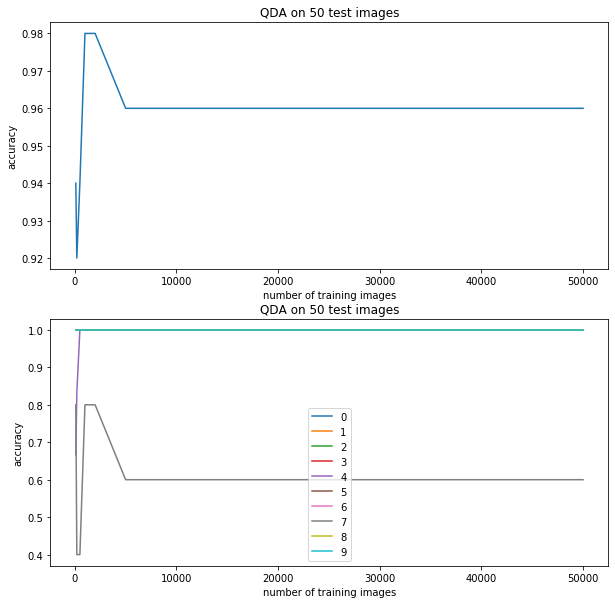

In [407]:
# QDA

sample_size_list = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]

accuracy_list = []
test_digit_counts = [list(test_label[:50]).count(i) for i in range(n_class)]
accuracy_list_digit = []


kernel = 'QDA'
n_test_samples = 50
for n_samples in sample_size_list:
    
    print('number training data: ' + str(n_samples))
    
    classes_few_data = classes_fn(train_label[:n_samples])
    mean_few_data = mean_fn(train_data[:n_samples], classes_few_data)
    cov_few_data = np.array([np.cov(train_data[classes[i]][:n_samples].T) for i in range(n_class)])

    
    predicted_data = predict(test_data, mean_few_data, cov_few_data, 0.001, priors, n_test_samples, kernel = kernel)
    
    ############ calculate total accuracies for every epoch########
    wrong_count = 0
    for idx, pred in enumerate(predicted_data):
        if pred == test_label[idx]:
                wrong_count += 0
        else:
                wrong_count += 1   
        
    accuracy = 1-wrong_count/n_test_samples
    accuracy_list.append(accuracy)
    
    print(str(wrong_count) + ' of ' + str(n_test_samples) + ' test data wrong       ' + str(accuracy) + ' accuracy')
    print('')
    
    ############ calculate accuracies per digit (class) for every epoch########
    
    digit_errors = np.zeros(n_class)
    for i in range(n_test_samples):
    
        if test_label[i] == 0 and predicted_data[i] != 0:
            digit_errors[0] += 1/test_digit_counts[0]
        if test_label[i] == 1 and predicted_data[i] != 1:
            digit_errors[1] += 1/test_digit_counts[1]
        if test_label[i] == 2 and predicted_data[i] != 2:
            digit_errors[2] += 1/test_digit_counts[2]
        if test_label[i] == 3 and predicted_data[i] != 3:
            digit_errors[3] += 1/test_digit_counts[3]
        if test_label[i] == 4 and predicted_data[i] != 4:
            digit_errors[4] += 1/test_digit_counts[4]
        if test_label[i] == 5 and predicted_data[i] != 5:
            digit_errors[5] += 1/test_digit_counts[5]
        if test_label[i] == 6 and predicted_data[i] != 6:
            digit_errors[6] += 1/test_digit_counts[6]
        if test_label[i] == 7 and predicted_data[i] != 7:
            digit_errors[7] += 1/test_digit_counts[7]
        if test_label[i] == 8 and predicted_data[i] != 8:
            digit_errors[8] += 1/test_digit_counts[8]
        if test_label[i] == 9 and predicted_data[i] != 9:
            digit_errors[9] += 1/test_digit_counts[9]
    
    accuracy_list_digit.append(digit_errors)
accuracy_list_digit = (1-np.array(accuracy_list_digit)).tolist()
    
    
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)    
plt.plot(sample_size_list, accuracy_list)
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.title(kernel + ' on ' + str(n_test_samples) + ' test images')

plt.subplot(2, 1, 2)
plt.plot(sample_size_list, accuracy_list_digit)
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.title(kernel + ' on ' + str(n_test_samples) + ' test images')
plt.legend(range(n_class))
plt.show()


plt.show()

In [423]:
predicted_data = predict(test_data, mean, cov, 0.001, priors, len(test_data), kernel = 'QDA')
    
    
wrong_count = 0
for idx, pred in enumerate(predicted_data):
    if pred == test_label[idx]:
            wrong_count += 0
    else:
            wrong_count += 1   

accuracy = 1-wrong_count/len(test_data)

print(str(wrong_count) + ' of ' + str(len(test_data)) + ' test data wrong       ' + str(accuracy) + ' accuracy')


332 of 50 test data wrong       0.9668 accuracy


In [126]:
# predict the test data
#
#
#

prediction_data = mnist_data['test_data']

n_images_prediction = len(prediction_data)
L2_norm_prediction = np.array([LA.norm(prediction_data[i]) for i in range(n_images_prediction)])
prediction_data = np.array([prediction_data[i]/L2_norm_prediction[i] for i in range(n_images_prediction)])

In [128]:
y_predictions = predict(prediction_data, mean, cov, 0.001, priors, len(prediction_data), kernel = 'QDA')

In [129]:
# A code snippet to help you save your results into a kaggle accepted csv
import pandas as pd

# Usage results_to_csv(clf.predict(X_test))
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission_MNIST.csv', index_label='Id')

results_to_csv(np.array(y_predictions))

# SPAM - HAM

In [502]:
# load training data

train_data = spam_data['training_data'][:4137]
train_label = spam_data['training_labels'][:4137]
n_images = len(train_data)

# normalize with L2 norm
L2_norm = np.array([LA.norm(train_data[i]) for i in range(n_images)])
train_data = np.array([train_data[i]/L2_norm[i] for i in range(n_images)])
train_data[np.isnan(train_data)]=0 # make NaN to 0

In [504]:
# load test data

test_data = spam_data['training_data'][4137:]
test_label = spam_data['training_labels'][4137:]
n_images_test = len(test_data)

# normalize with L2 norm
L2_norm_test = np.array([LA.norm(test_data[i]) for i in range(n_images_test)])
test_data = np.array([test_data[i]/L2_norm_test[i] for i in range(n_images_test)])
test_data[np.isnan(test_data)]=0 # make NaN to 0

In [505]:
test_data.shape

(1035, 32)

In [506]:
# define useful numbers

n_class = int(max(train_label+1))
dim = len(train_data[0])

print('n_images = ', n_images)
print('n_images_test = ', n_images_test)
print('n_class = ', n_class)
print('dim = ', dim)

n_images =  4137
n_images_test =  1035
n_class =  2
dim =  32


In [507]:
classes = classes_fn(train_label)
classes

[array([1500, 1501, 1502, ..., 4134, 4135, 4136]),
 array([   0,    1,    2, ..., 1497, 1498, 1499])]

In [508]:
priors = np.array([len(train_data[classes[i]])/n_images for i in range(n_class)])
priors

array([0.63741842, 0.36258158])

In [509]:
mean = mean_fn(train_data, classes)
mean

array([[2.18942082e-04, 2.17105156e-03, 2.23870540e-03, 4.51903290e-03,
        0.00000000e+00, 3.86952127e-07, 9.20553321e-06, 2.53077003e-06,
        2.85038312e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.47468819e-02, 4.42101267e-02, 1.75223337e-02, 3.34908138e-02,
        5.59072167e-02, 1.31073564e-02, 8.90766392e-03, 1.35832124e-01,
        6.02051537e-03, 5.23207086e-03, 1.67590486e-03, 3.09074984e-03,
        5.62889588e-02, 8.27769210e-02, 6.35053302e-02, 1.09514260e-01,
        7.33533723e-02, 2.93818209e-01, 6.96430649e-03, 9.95179251e-02],
       [2.83984549e-02, 1.51618318e-02, 1.22105579e-02, 4.73722699e-02,
        6.53191808e-03, 1.10564441e-02, 2.88830415e-02, 3.54201585e-03,
        3.36302635e-03, 5.75700199e-03, 8.99742140e-03, 4.21415056e-03,
        3.92530882e-02, 1.55202183e-02, 2.77683667e-02, 4.94345735e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.27260070e-03, 2.70587057e-03, 4.68053

In [510]:
# calculate covariance matrix for each class

cov = np.array([np.cov(train_data[classes[i]].T) for i in range(n_class)])

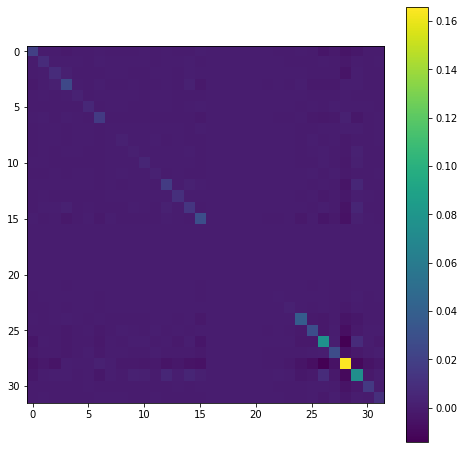

In [511]:
plt.figure(figsize=(8,8))
plt.imshow(cov[1]);
plt.colorbar()
plt.show()

In [512]:
predicted_data = predict(test_data, mean, cov, 0.001, priors, 50, kernel = 'LDA')
predicted_data

array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

number training data: 100
0 of 1035 test data wrong       1.0 accuracy

number training data: 200
0 of 1035 test data wrong       1.0 accuracy

number training data: 500
0 of 1035 test data wrong       1.0 accuracy

number training data: 1000
0 of 1035 test data wrong       1.0 accuracy

number training data: 2000
81 of 1035 test data wrong       0.9217391304347826 accuracy

number training data: 5000
75 of 1035 test data wrong       0.927536231884058 accuracy

number training data: 10000
75 of 1035 test data wrong       0.927536231884058 accuracy

number training data: 30000
75 of 1035 test data wrong       0.927536231884058 accuracy

number training data: 50000
75 of 1035 test data wrong       0.927536231884058 accuracy



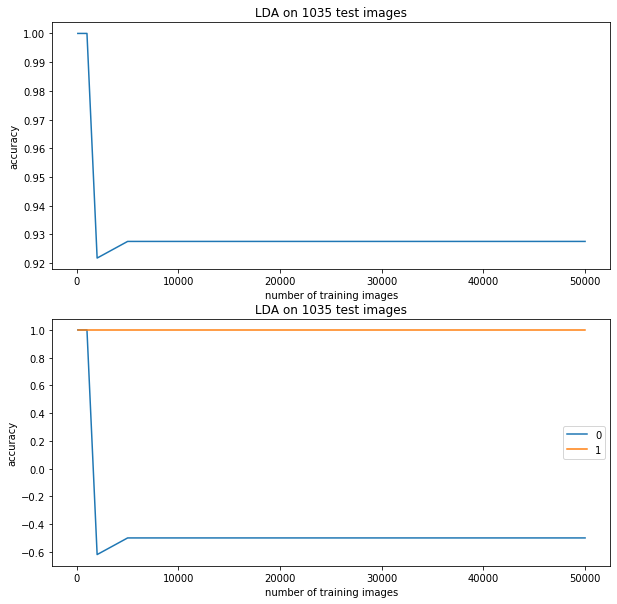

In [513]:
# LDA

sample_size_list = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]

accuracy_list = []
test_digit_counts = [list(test_label[:50]).count(i) for i in range(n_class)]
accuracy_list_digit = []


kernel = 'LDA'
n_test_samples = len(test_data)
for n_samples in sample_size_list:
    
    print('number training data: ' + str(n_samples))
    
    classes_few_data = classes_fn(train_label[:n_samples])
    mean_few_data = mean_fn(train_data[:n_samples], classes_few_data)
    cov_few_data = np.array([np.cov(train_data[classes[i]][:n_samples].T) for i in range(n_class)])

    
    predicted_data = predict(test_data, mean_few_data, cov_few_data, 0.001, priors, n_test_samples, kernel = kernel)
    
    ############ calculate total accuracies for every epoch########
    wrong_count = 0
    for idx, pred in enumerate(predicted_data):
        if pred == test_label[idx]:
                wrong_count += 0
        else:
                wrong_count += 1   
        
    accuracy = 1-wrong_count/n_test_samples
    accuracy_list.append(accuracy)
    
    print(str(wrong_count) + ' of ' + str(n_test_samples) + ' test data wrong       ' + str(accuracy) + ' accuracy')
    print('')
    
    ############ calculate accuracies per digit (class) for every epoch########
    
    digit_errors = np.zeros(n_class)
    for i in range(n_test_samples):
    
        if test_label[i] == 0 and predicted_data[i] != 0:
            digit_errors[0] += 1/test_digit_counts[0]
        if test_label[i] == 1 and predicted_data[i] != 1:
            digit_errors[1] += 1/test_digit_counts[1]
        if test_label[i] == 2 and predicted_data[i] != 2:
            digit_errors[2] += 1/test_digit_counts[2]
        if test_label[i] == 3 and predicted_data[i] != 3:
            digit_errors[3] += 1/test_digit_counts[3]
        if test_label[i] == 4 and predicted_data[i] != 4:
            digit_errors[4] += 1/test_digit_counts[4]
        if test_label[i] == 5 and predicted_data[i] != 5:
            digit_errors[5] += 1/test_digit_counts[5]
        if test_label[i] == 6 and predicted_data[i] != 6:
            digit_errors[6] += 1/test_digit_counts[6]
        if test_label[i] == 7 and predicted_data[i] != 7:
            digit_errors[7] += 1/test_digit_counts[7]
        if test_label[i] == 8 and predicted_data[i] != 8:
            digit_errors[8] += 1/test_digit_counts[8]
        if test_label[i] == 9 and predicted_data[i] != 9:
            digit_errors[9] += 1/test_digit_counts[9]
    
    accuracy_list_digit.append(digit_errors)
accuracy_list_digit = (1-np.array(accuracy_list_digit)).tolist()
    
    
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)    
plt.plot(sample_size_list, accuracy_list)
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.title(kernel + ' on ' + str(n_test_samples) + ' test images')

plt.subplot(2, 1, 2)
plt.plot(sample_size_list, accuracy_list_digit)
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.title(kernel + ' on ' + str(n_test_samples) + ' test images')
plt.legend(range(n_class))
plt.show()


plt.show()

number training data: 100
0 of 1035 test data wrong       1.0 accuracy

number training data: 200
0 of 1035 test data wrong       1.0 accuracy

number training data: 500
0 of 1035 test data wrong       1.0 accuracy

number training data: 1000
0 of 1035 test data wrong       1.0 accuracy

number training data: 2000
152 of 1035 test data wrong       0.8531400966183575 accuracy

number training data: 5000
151 of 1035 test data wrong       0.8541062801932368 accuracy

number training data: 10000
151 of 1035 test data wrong       0.8541062801932368 accuracy

number training data: 30000
151 of 1035 test data wrong       0.8541062801932368 accuracy

number training data: 50000
151 of 1035 test data wrong       0.8541062801932368 accuracy



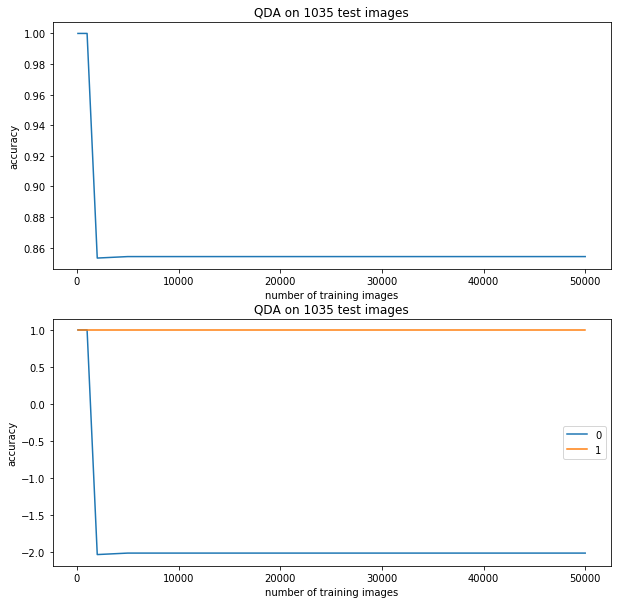

In [514]:
# QDA

sample_size_list = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]

accuracy_list = []
test_digit_counts = [list(test_label[:50]).count(i) for i in range(n_class)]
accuracy_list_digit = []


kernel = 'QDA'
n_test_samples = len(test_data)
for n_samples in sample_size_list:
    
    print('number training data: ' + str(n_samples))
    
    classes_few_data = classes_fn(train_label[:n_samples])
    mean_few_data = mean_fn(train_data[:n_samples], classes_few_data)
    cov_few_data = np.array([np.cov(train_data[classes[i]][:n_samples].T) for i in range(n_class)])

    
    predicted_data = predict(test_data, mean_few_data, cov_few_data, 0.001, priors, n_test_samples, kernel = kernel)
    
    ############ calculate total accuracies for every epoch########
    wrong_count = 0
    for idx, pred in enumerate(predicted_data):
        if pred == test_label[idx]:
                wrong_count += 0
        else:
                wrong_count += 1   
        
    accuracy = 1-wrong_count/n_test_samples
    accuracy_list.append(accuracy)
    
    print(str(wrong_count) + ' of ' + str(n_test_samples) + ' test data wrong       ' + str(accuracy) + ' accuracy')
    print('')
    
    ############ calculate accuracies per digit (class) for every epoch########
    
    digit_errors = np.zeros(n_class)
    for i in range(n_test_samples):
    
        if test_label[i] == 0 and predicted_data[i] != 0:
            digit_errors[0] += 1/test_digit_counts[0]
        if test_label[i] == 1 and predicted_data[i] != 1:
            digit_errors[1] += 1/test_digit_counts[1]
        if test_label[i] == 2 and predicted_data[i] != 2:
            digit_errors[2] += 1/test_digit_counts[2]
        if test_label[i] == 3 and predicted_data[i] != 3:
            digit_errors[3] += 1/test_digit_counts[3]
        if test_label[i] == 4 and predicted_data[i] != 4:
            digit_errors[4] += 1/test_digit_counts[4]
        if test_label[i] == 5 and predicted_data[i] != 5:
            digit_errors[5] += 1/test_digit_counts[5]
        if test_label[i] == 6 and predicted_data[i] != 6:
            digit_errors[6] += 1/test_digit_counts[6]
        if test_label[i] == 7 and predicted_data[i] != 7:
            digit_errors[7] += 1/test_digit_counts[7]
        if test_label[i] == 8 and predicted_data[i] != 8:
            digit_errors[8] += 1/test_digit_counts[8]
        if test_label[i] == 9 and predicted_data[i] != 9:
            digit_errors[9] += 1/test_digit_counts[9]
    
    accuracy_list_digit.append(digit_errors)
accuracy_list_digit = (1-np.array(accuracy_list_digit)).tolist()
    
    
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)    
plt.plot(sample_size_list, accuracy_list)
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.title(kernel + ' on ' + str(n_test_samples) + ' test images')

plt.subplot(2, 1, 2)
plt.plot(sample_size_list, accuracy_list_digit)
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.title(kernel + ' on ' + str(n_test_samples) + ' test images')
plt.legend(range(n_class))
plt.show()


plt.show()

In [515]:
# predict the test data
#
#
#

prediction_data = spam_data['test_data']

n_images_prediction = len(prediction_data)
L2_norm_prediction = np.array([LA.norm(prediction_data[i]) for i in range(n_images_prediction)])
prediction_data = np.array([prediction_data[i]/L2_norm_prediction[i] for i in range(n_images_prediction)])
prediction_data[np.isnan(prediction_data)]=0 # make NaN to 0

In [516]:
y_predictions = predict(prediction_data, mean, cov, 0.001, priors, len(prediction_data), kernel = 'LDA')

In [518]:
# A code snippet to help you save your results into a kaggle accepted csv
import pandas as pd

# Usage results_to_csv(clf.predict(X_test))
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission_SPAM.csv', index_label='Id')

results_to_csv(np.array(y_predictions))